In [1]:
# Source paper for UCSD data: https://pubs.aip.org/aip/jrse/article/13/2/025301/926842
# Source for wind data: https://pureportal.strath.ac.uk/en/datasets/australian-electricity-market-operator-aemo-5-minute-wind-power-d

In [2]:
import csv
from cvxpy import *
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

Reading: Building Load Data/GeiselLibrary.csv
(87797, 3)


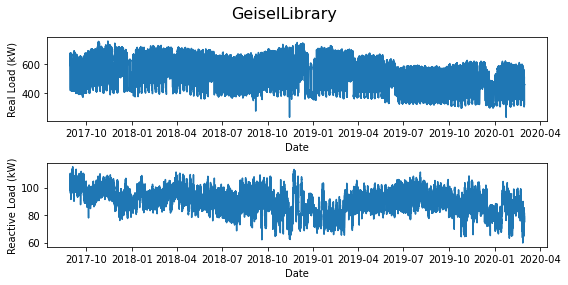

Reading: Building Load Data/OttersonHall.csv
(155609, 3)


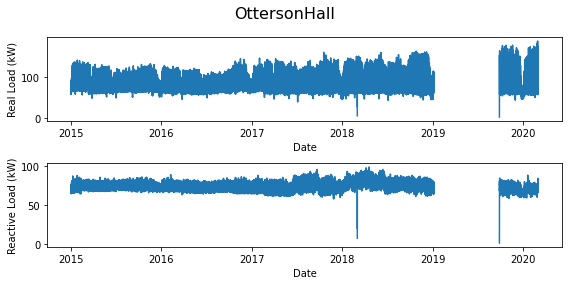

Reading: Building Load Data/StudentServices.csv
(131269, 3)


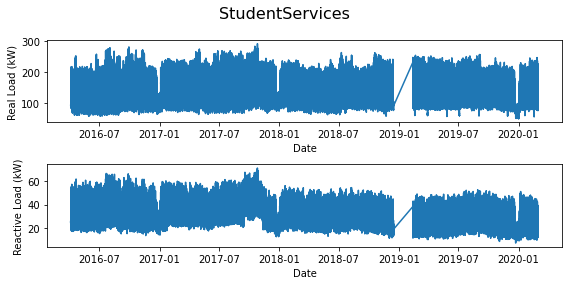

Reading: Building Load Data/Mandeville.csv
(180964, 3)


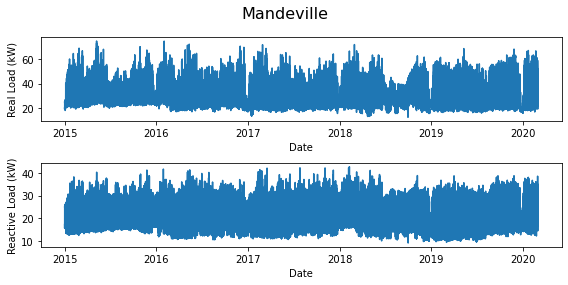

Reading: Building Load Data/RadyHall.csv
(181048, 3)


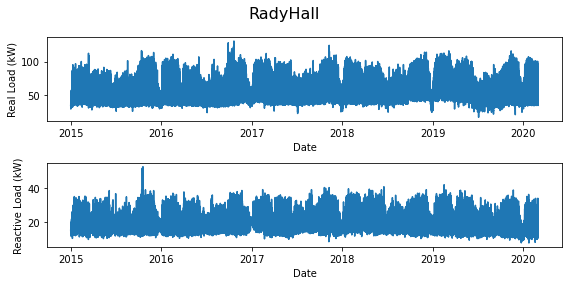

Reading: Building Load Data/RobinsonHall.csv
(141447, 3)


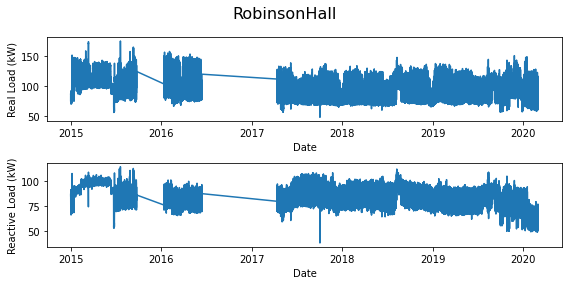

Reading: Building Load Data/SocialScience.csv
(113826, 3)


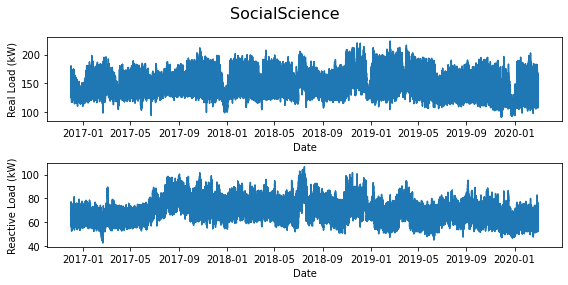

Reading: Building Load Data/CenterHall.csv
(145393, 3)


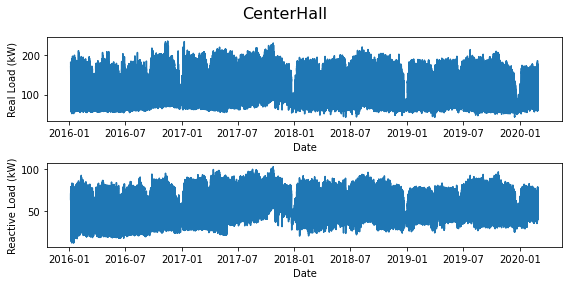

Reading: Building Load Data/PepperCanyon.csv
(177574, 3)


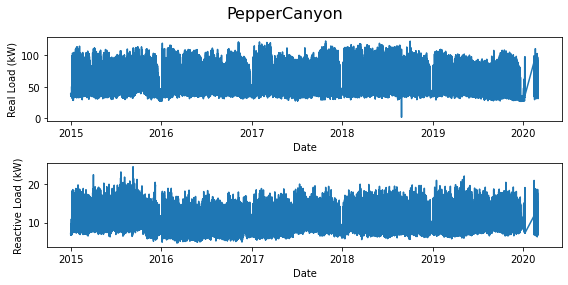

Reading: Building Load Data/GalbraithHall.csv
(181045, 3)


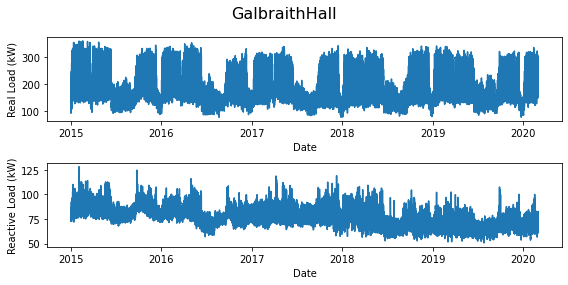

Reading: Building Load Data/MusicBuilding.csv
(122929, 3)


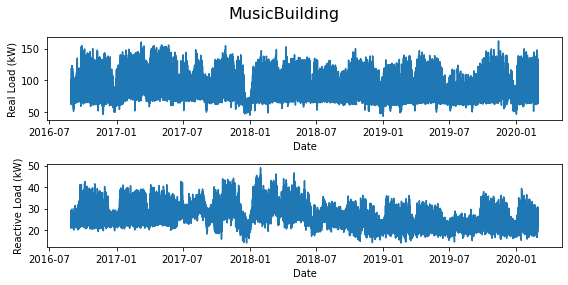

Reading: Building Load Data/EastCampus.csv
(92757, 3)


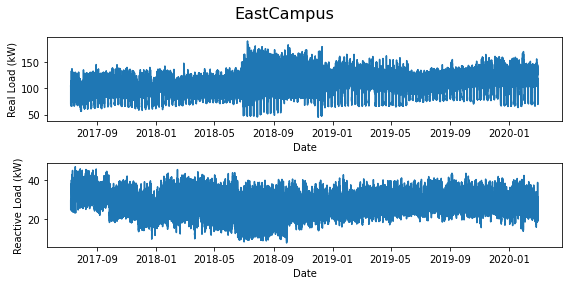

In [3]:
# Import building load data (takes about 3 minutes to read-in)
directory = 'Building Load Data'
real_load = pd.DataFrame()
reactive_load = pd.DataFrame()

# Iterate through all files in the directory
for file in os.listdir(directory):
    
    if file.endswith(".csv"):                                      # only iterate over csv files
        filepath = os.path.join(directory, file)                   # Get the full file path
        filename = os.path.splitext(os.path.basename(filepath))[0] # use filename as column name
        
        print("Reading:", filepath)
        data_in = pd.read_csv(filepath, parse_dates=['DateTime'])
        print(data_in.shape)

        fig, ax = plt.subplots(2, figsize=(8, 4)) 
        fig.suptitle(filename, fontsize=16) 

        ax[0].plot(data_in.iloc[:,0], data_in.iloc[:,1])
        ax[0].set_xlabel('Date')
        ax[0].set_ylabel('Real Load (kW)')

        ax[1].plot(data_in.iloc[:,0], data_in.iloc[:,2])
        ax[1].set_xlabel('Date')
        ax[1].set_ylabel('Reactive Load (kW)')
        plt.tight_layout()
        plt.show()

        real_load[filename] = data_in.iloc[:, 1] # real power in column B of excel sheet
        reactive_load[filename] = data_in.iloc[:, 2] # real power in column C of excel sheet

In [4]:
# Get date column
for file in os.listdir(directory):
    if file.endswith(".csv"):                      # only iterate over csv files
        filepath = os.path.join(directory, file)   # Get the full file path
        data_in = pd.read_csv(filepath, parse_dates=['DateTime'])
        real_load['date'] = data_in.iloc[:, 0]     # only extract datetime
        reactive_load['date'] = data_in.iloc[:, 0] # only extract datetime
        break # only need to extract date column from one of the files

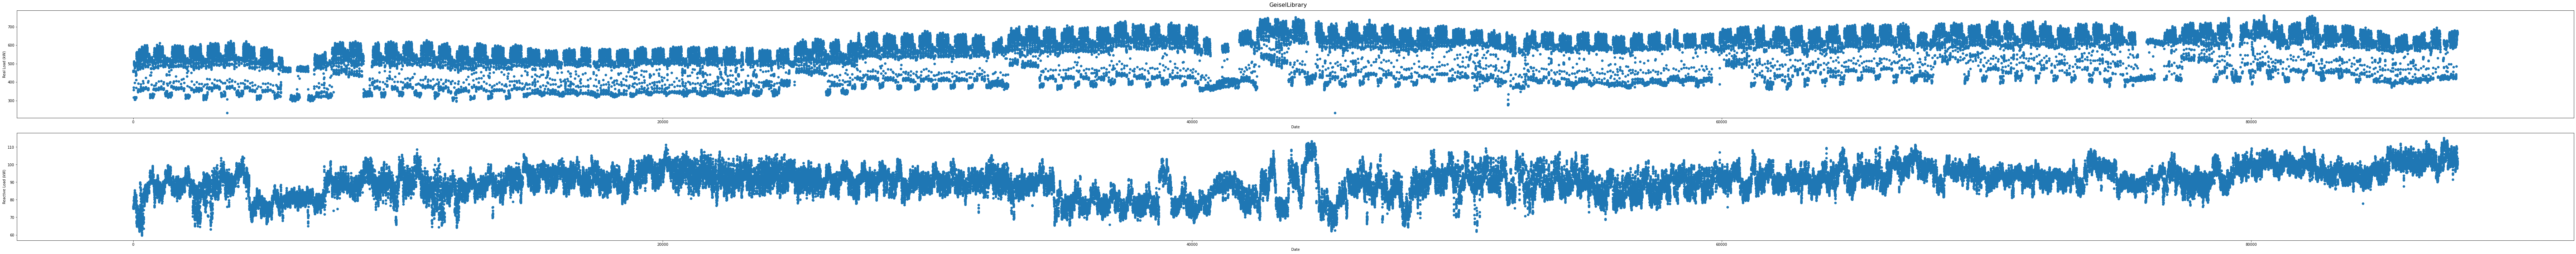

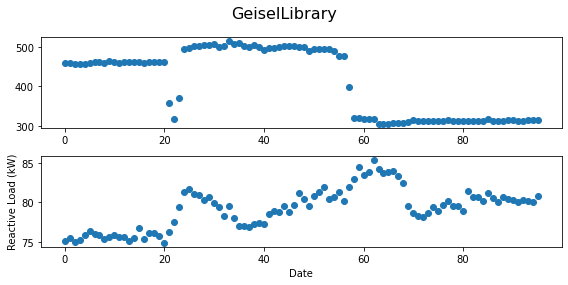

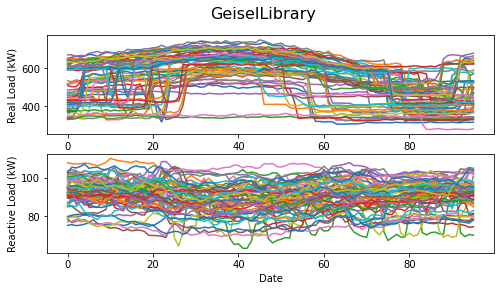

In [5]:
# Try to visualize the data (just try one building to start)

# Full time period
for column in real_load.columns:

    fig, ax = plt.subplots(2, figsize=(100, 10)) 
    fig.suptitle(column, fontsize=16) 

    ax[0].scatter(real_load.index, real_load[column])
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Real Load (kW)')

    ax[1].scatter(reactive_load.index, reactive_load[column])
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Reactive Load (kW)')
    plt.tight_layout()
    plt.show()

    break

# Approximately one day
for column in real_load.columns:
    
    fig, ax = plt.subplots(2, figsize=(8, 4)) 
    fig.suptitle(column, fontsize=16) 

    ax[0].scatter(range(96), real_load[column][0:96])
    

    ax[1].scatter(range(96), reactive_load[column][0:96])
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Reactive Load (kW)')
    plt.tight_layout()
    plt.show()

    break

# Plot multiple days for just one building (plot every 15 days, otherwise overwhelming)
num_data_points = real_load.shape[0]
day_length = 96 # data point every 15 minutes --> 4 points per hour, 24 hours per day
num_days = int(np.floor(num_data_points/day_length))

for column in real_load.columns:
    
    fig, ax = plt.subplots(2, figsize=(8, 4)) 
    fig.suptitle(column, fontsize=16)

    for day in range(0, num_days, 15):
        start = day_length * day
        end = start + day_length       
        
        ax[0].plot(range(0, day_length), real_load[column][start:end], label=f'day {day + 1}')
        ax[0].set_xlabel('Date')
        ax[0].set_ylabel('Real Load (kW)')

        ax[1].plot(range(0, day_length), reactive_load[column][start:end])
        ax[1].set_xlabel('Date')
        ax[1].set_ylabel('Reactive Load (kW)')
    
    plt.show()
    
    break

In [6]:
# DECISION: 
# - Use 914 days worth of data starting from March 2015, because that is what is common across all of the buildings
# - For each building, collect the daily profiles into their own dataframe, with columns as days and rows as times
# - These profiles can be deterministically or randomly selected as the generation profile for a given day in the optimal control problem

real_dict = {}
reactive_dict = {}

for column in real_load.columns:
    real_data     = np.zeros([num_days, day_length])
    reactive_data = np.zeros([num_days, day_length])

    for day in range(num_days):
        start = day_length * day
        end = start + day_length       
        real_data[day, :]     = real_load[column][start:end]  
        reactive_data[day, :] = reactive_load[column][start:end]  

    real_dict[column] = real_data.tolist() # use LoL as numpy arrays are not json serializable
    reactive_dict[column] = reactive_data.tolist()

with open('Building Load Data/real_power_data.json', 'w') as json_file:
    json.dump(real_dict, json_file)

with open('Building Load Data/reactive_power_data.json', 'w') as json_file:
    json.dump(reactive_dict, json_file)

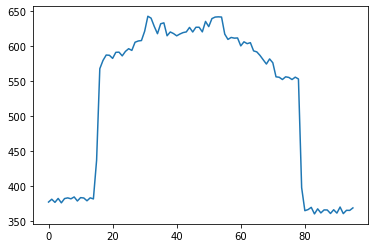

In [7]:
# Check that the json data was written correctly
with open('Building Load Data/real_power_data.json', 'r') as json_file:
    real_dict_r = json.load(json_file)

    for key in real_dict_r.keys(): # test on first key only
        real_data = np.array(real_dict_r[key])
        plt.plot(range(real_data.shape[1]), real_data[422, :]) # e.g. for day 422
        break

In [3]:
# NOW READ-IN THE WIND DATA

Reading: Wind Data/wind_data.csv


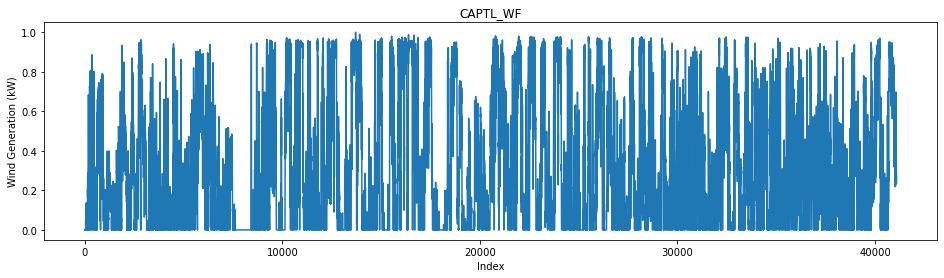

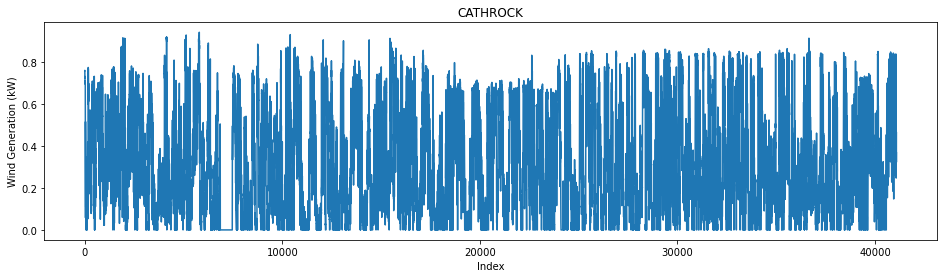

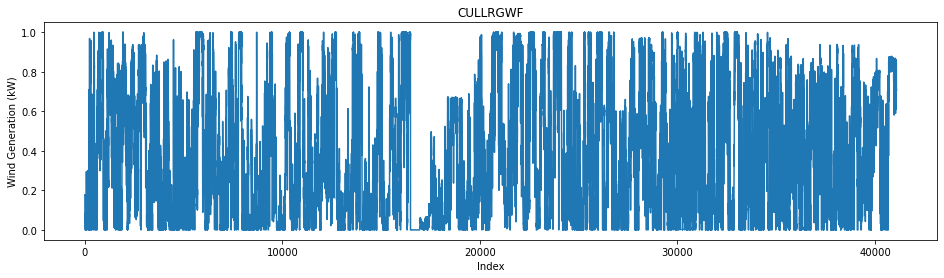

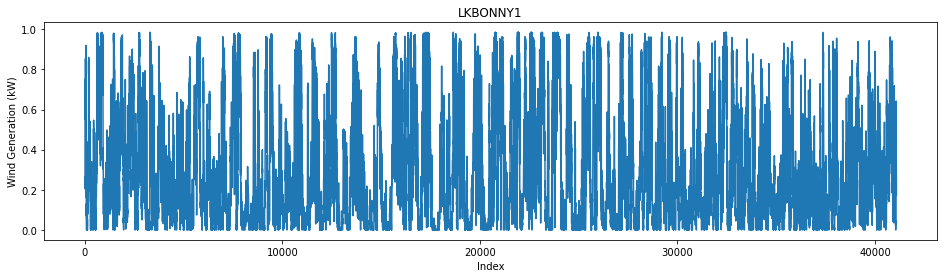

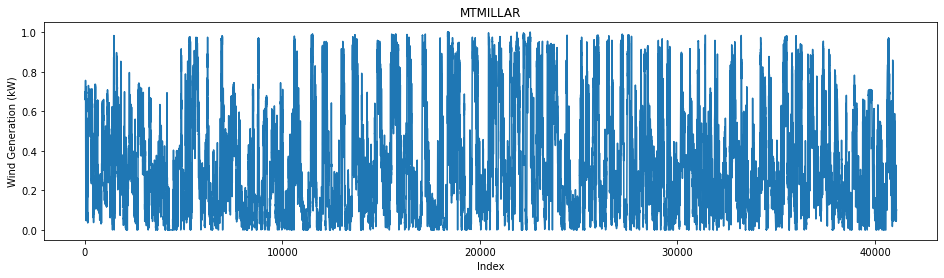

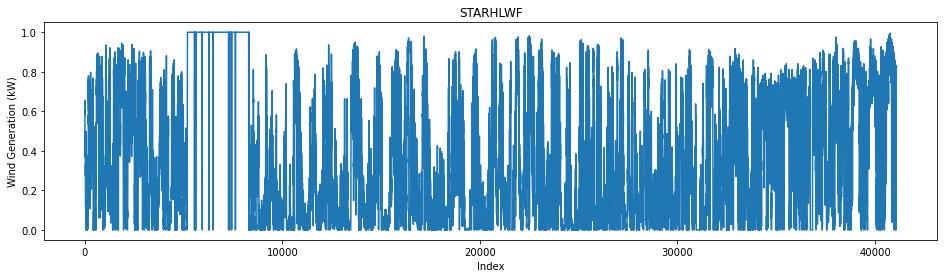

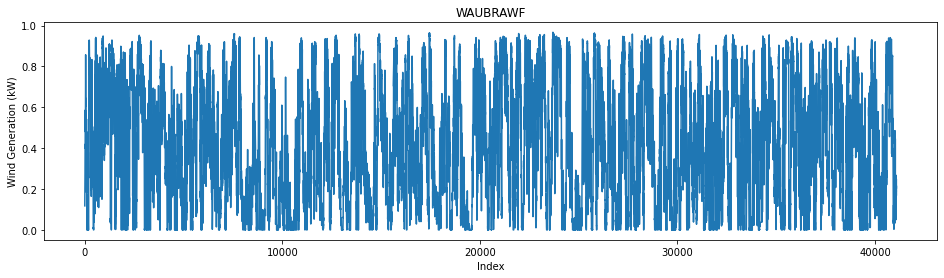

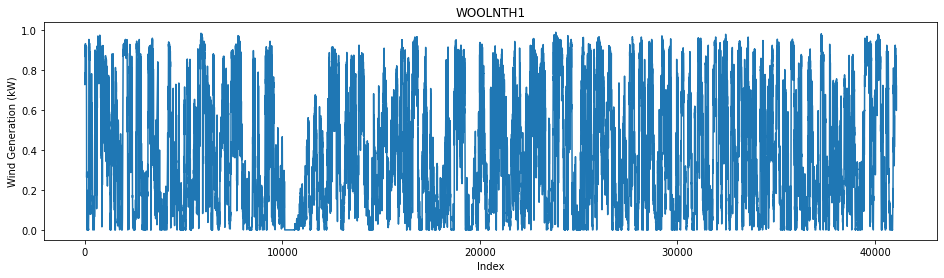

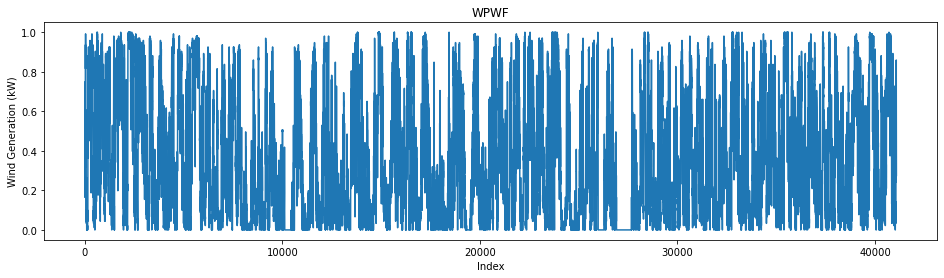

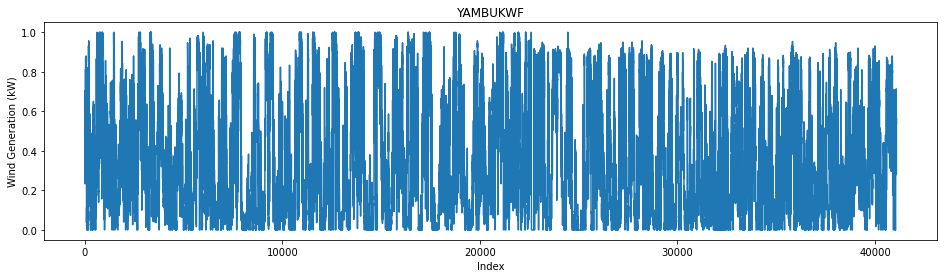

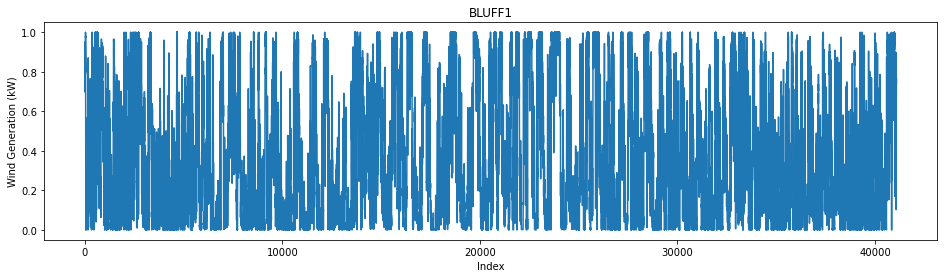

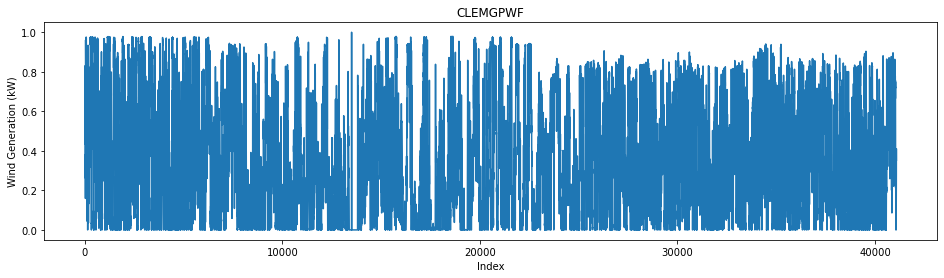

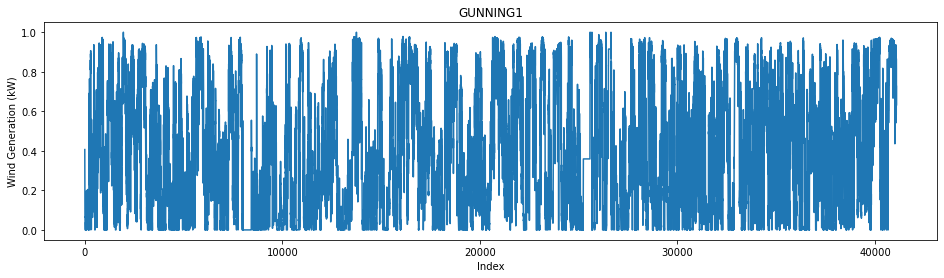

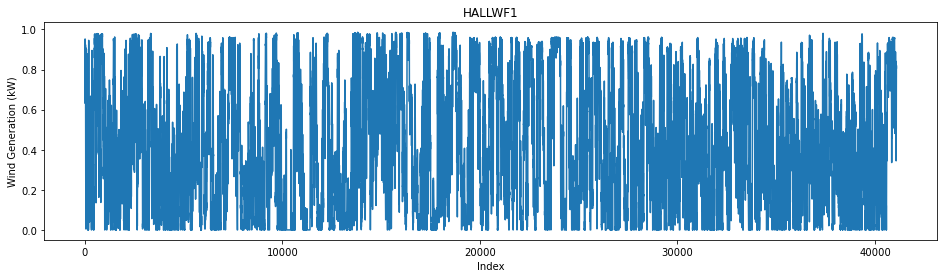

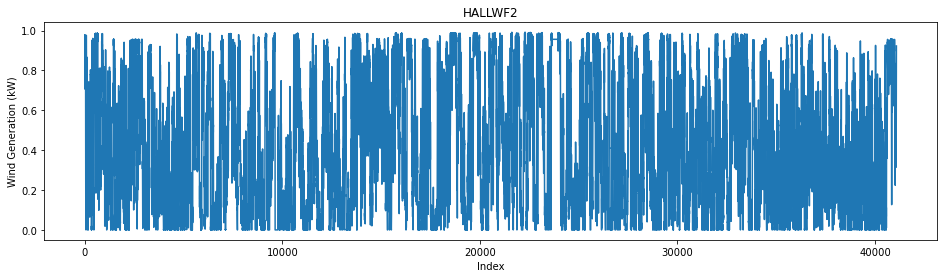

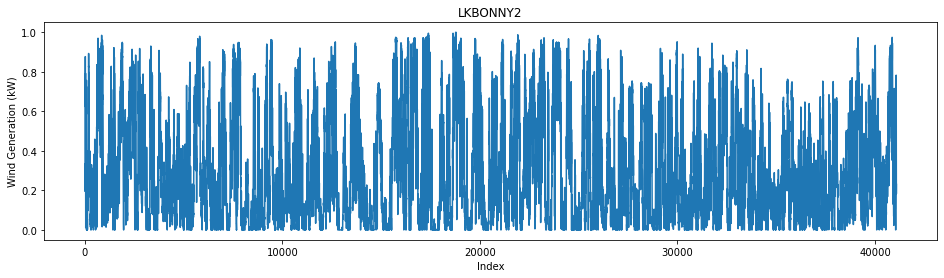

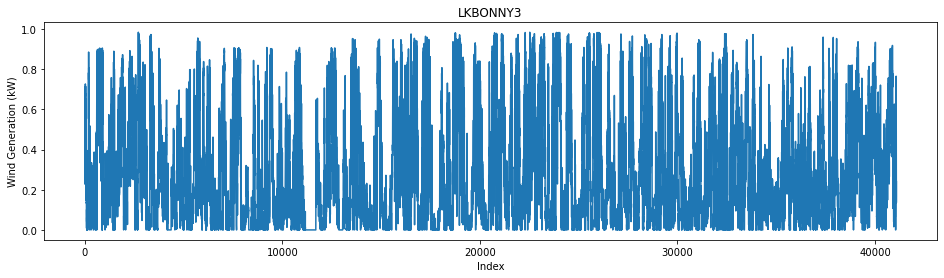

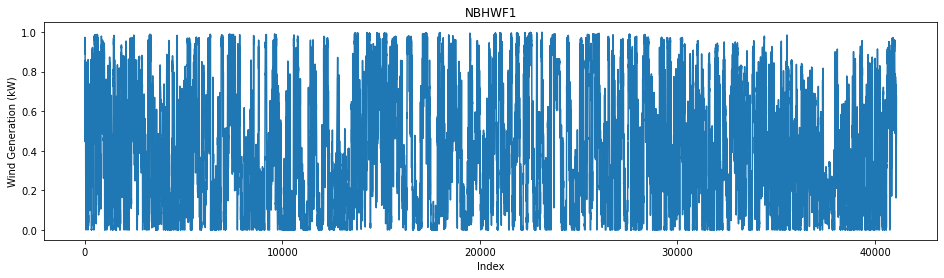

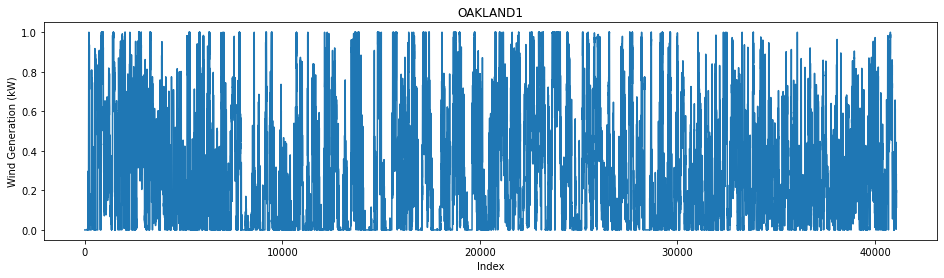

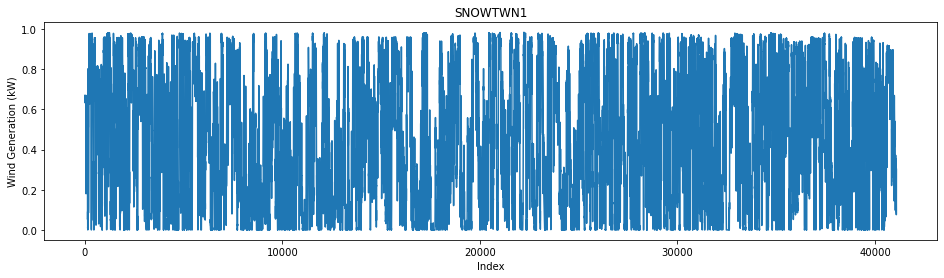

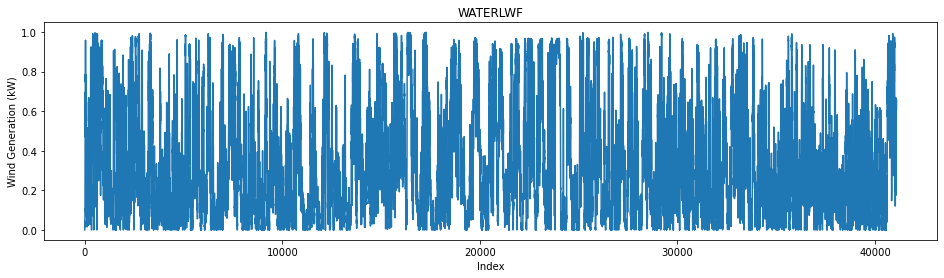

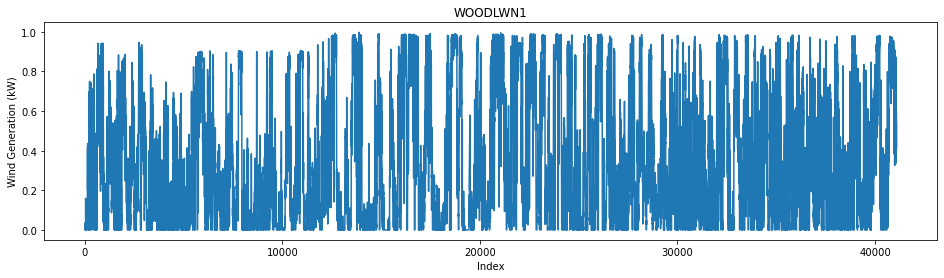

(41085, 22)


In [33]:
# Import data data
directory = 'Wind Data'
file = 'wind_data.csv'
wind_data = pd.DataFrame()

# Iterate through all columns in the file
filepath = os.path.join(directory, file) 
print("Reading:", filepath)

data_in = pd.read_csv(filepath)

# Other datasets used datetime, instead of separate date and time
date_df = pd.to_datetime(data_in['Date'] + ' ' + data_in['Time'])

# Parse out the desired data
# This data is in 5 min increments, but downsample to 15 min

start = 239 # first full day doesn't begin until 1/1/2012
end   = 123494 # we only want 474 days, to match the solar dataset (474 days x 24 hours x 12 points/hour)
date_df = date_df[start:end:3]

for column in data_in:
    if column == 'Date' or column == 'Time':
        continue # we don't need the date or time columns
    wind_df = data_in[column][start:end:3] 
    wind_data[column] = wind_df.tolist()

    plt.figure(figsize=(16, 4))
    plt.plot(wind_data[column].index, wind_data[column])
    plt.xlabel('Index')
    plt.ylabel('Wind Generation (kW)')
    plt.title(column)
    plt.show()

print(wind_data.shape)

In [34]:
# Since we started at row 239 and took every 3 data points (downsampling from 5 to 15 min), we need to reindex the dateframes
date_df.reset_index(drop=True, inplace=True)
wind_data.reset_index(drop=True, inplace=True)
print(wind_data)

       CAPTL_WF  CATHROCK  CULLRGWF  LKBONNY1  MTMILLAR  STARHLWF  WAUBRAWF  \
0      0.000000  0.757576  0.175479  0.217449  0.698739  0.582319  0.117734   
1      0.000000  0.759242  0.174665  0.229653  0.667911  0.605507  0.131870   
2      0.000000  0.743636  0.144961  0.236309  0.659300  0.637391  0.146943   
3      0.000000  0.742121  0.165306  0.237419  0.694806  0.654783  0.158552   
4      0.000000  0.741818  0.175682  0.245185  0.695869  0.634493  0.167583   
...         ...       ...       ...       ...       ...       ...       ...   
41080  0.398343  0.466061  0.802930  0.264045  0.055597  0.830918  0.201953   
41081  0.339314  0.400303  0.802726  0.222996  0.085150  0.801932  0.216516   
41082  0.278057  0.371667  0.788281  0.228543  0.068885  0.772947  0.204505   
41083  0.235000  0.322576  0.703237  0.197479  0.105454  0.782609  0.176635   
41084  0.278543  0.367273  0.709341  0.173072  0.099714  0.821256  0.171375   

       WOOLNTH1      WPWF  YAMBUKWF  ...  GUNNING1 

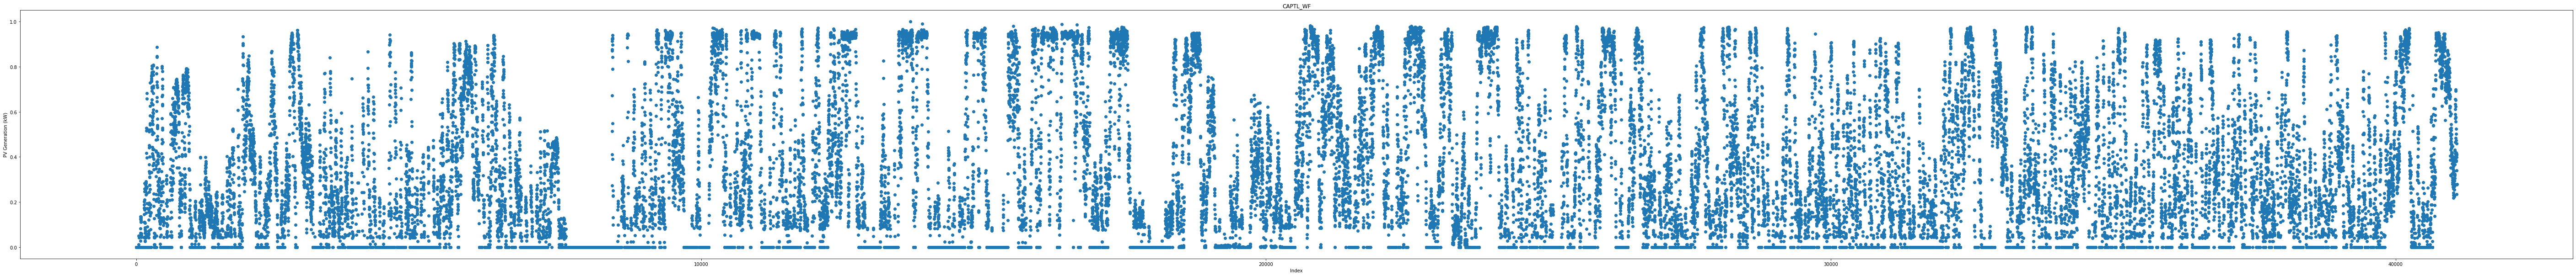

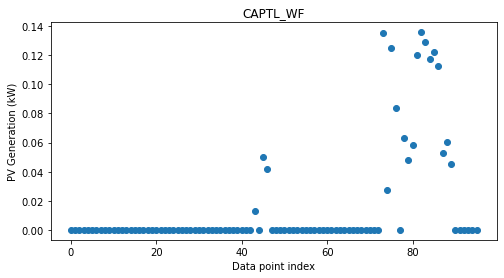

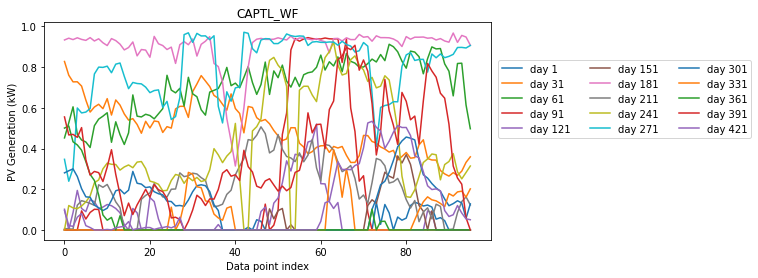

In [38]:
# Try to visualize the data (just try one city to start)

# Full time period
for column in wind_data.columns:
    plt.figure(figsize=(100, 10))
    plt.scatter(wind_data.index, wind_data[column])
    plt.xlabel('Index')
    plt.ylabel('PV Generation (kW)')
    plt.title(column)
    plt.show()
    break

# Approximately one day
for column in wind_data.columns:
    plt.figure(figsize=(8, 4))
    plt.scatter(wind_data.index[0:96], wind_data[column][0:96])
    plt.xlabel('Data point index')
    plt.ylabel('PV Generation (kW)')
    plt.title(column)
    plt.show()
    break

# Plot multiple days for just one PV generator (plot every 15 days, otherwise overwhelming)
num_data_points = wind_data.shape[0]
day_length = 96 # data point every 15 minutes --> 4 points per hour, 24 hours per day
num_days = int(np.floor(num_data_points/day_length))

for column in wind_data.columns:
    
    plt.figure(figsize=(8, 4)) 
    for day in range(0, num_days, 30):
        start = day_length * day
        end = start + day_length       
        plt.plot(range(0, day_length), wind_data[column][start:end], label=f'day {day + 1}')
    
    plt.xlabel('Data point index')
    plt.ylabel('PV Generation (kW)')
    plt.title(column)
    plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.85), ncol=3)
    plt.show()
    
    break


In [39]:
# DECISION: 
# - Use 427 days worth of data starting from Jan 2012, because that is how much date we have from UCSD
# - For each city, collect the daily profiles into their own dataframe, with columns as days and rows as times
# - These profiles can be deterministically or randomly selected as the generation profile for a given day as the RL environment

# Create a dictionary, keyed by city name, with daily data over the 427 days
wind_dict = {}
for column in wind_data.columns:
    daily_data = np.zeros([num_days, day_length])

    for day in range(num_days):
        start = day_length * day
        end = start + day_length       
        daily_data[day, :] = wind_data[column][start:end]  

    wind_dict[column] = daily_data.tolist() # use LoL as numpy arrays are not json serializable

with open('Wind Data/wind_data.json', 'w') as json_file:
    json.dump(wind_dict, json_file)

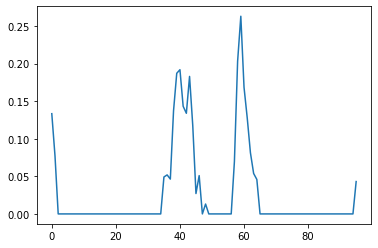

In [41]:
# Check that the json data was written correctly
with open('Wind Data/wind_data.json', 'r') as json_file:
    wind_dict_r = json.load(json_file)

    for key in wind_dict_r.keys(): # test on first key only
        daily_data = np.array(wind_dict_r[key])
        plt.plot(range(daily_data.shape[1]), daily_data[422, :]) # e.g. for day 422
        break